# Reg GAN

In [14]:
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
import yfinance as yf
from datetime import datetime
# Move to GeomPrior/aria `pip install -e ./`
import aria 
from aria.components.dataframe_regressor import DataFrameRegressor
from aria.components.fourier_seasonality import FourierSeasonality
from aria.components.linear_trend import LinearTrend
from aria.components.linear_trend_changepoints import LinearTrendChangepoints
from aria.models.forward_stepwise_selector import ForwardStepwiseSelector
from aria.models.linear_lasso import LinearLassoModel
from aria.models.linear_ridge import LinearRidgeModel
from aria.models.clustering import ists
from aria.utils.evaluation import smape, bic, dtw_path, to_time_series
from scipy.spatial.distance import cdist
import matplotlib.pyplot as plt
#from tslearn import metrics 
#!python -m pip install cython
#!conda config --set channel_priority false
#!python -m pip install https://github.com/tslearn-team/tslearn/archive/main.zip
#conda install -c conda-forge lxm
np.random.seed(0)

from cases import datelib_spec
import importlib
importlib.reload(datelib_spec)

ModuleNotFoundError: No module named 'pairs_storage'

In [35]:
"""
This is the reimplementation of ists algortihm and sis software
"""
from __future__ import division
import numpy as np
from scipy import interpolate
import os

class ists:
    @staticmethod
    def readTrainingParams():
        #Program changes the working directory as files are opened
        #These lines ensure the training data is located
        previous_directory = os.getcwd()
        #input_file_directory = os.path.dirname(os.path.realpath(sys.argv[0]))
        #input_file_directory += "\\lib"
        __file__ = os.getcwd()
        root_dir = os.path.dirname(os.path.realpath(__file__))
        traindata_dir = 'lib'
        input_file_directory = os.path.join(root_dir, traindata_dir)
        os.chdir(input_file_directory)
        input_file = "ISTS_Training_Data_07_2013.txt"
        training_data = open(input_file)
        
        #===========================================================================
        # Read Training Parameters
        #===========================================================================
        _type = np.array(training_data.readline(), np.int32)        #1
        _key = np.array(training_data.readline(), np.int32)         #1
        nsegments = np.array(training_data.readline(), np.int32)    #number of segments = 12
        nstates = np.array(training_data.readline(), np.int32)      #number of states = 7
        nclass = np.array(training_data.readline(), np.int32)       #number of classes = 25
        source = []
        for _i in range(nclass):
            source = np.append(source, np.array(training_data.readline(), np.int32))
        
        #===========================================================================
        # Main loop
        # Iterated i's are [3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 23]
        #===========================================================================
        loop = True
        params = {}
        while loop:
            
            #i = np.array(training_data.readline(), np.int32)
            i = int(training_data.readline())
            #print "-"*5,i,"-"*5
            
            p = np.matrix(np.empty((nstates,1)))
            for j in range(nstates):
                for k in range(1):
                    
                    p[j,k] =  np.array(training_data.readline(), np.float64)
            
            A = np.matrix(np.empty((nstates,nstates*(nsegments-1))))
            for j in range(nstates):
                for k in range(nstates*(nsegments-1)):
                    A[j,k] =  np.array(training_data.readline(), np.float64)
            
            m = np.matrix(np.empty((3,nstates)))
            for j in range(3):
                for k in range(nstates):
                    m[j,k] =  np.array(training_data.readline(), np.float64)
            
            V = np.matrix(np.empty((3,3*nstates)))
            for j in range(3):
                for k in range(3*nstates):
                    V[j,k] =  np.array(training_data.readline(), np.float64)
            
            samsz = np.array(training_data.readline(), np.int32)
        
            lkd = np.empty(samsz)
            for j in range(samsz):
                lkd[j] = np.array(training_data.readline(), np.float64)
            
            st = np.matrix(np.empty((samsz,nsegments)))
            for j in range(samsz):
                for k in range(nsegments):
                    st[j,k] =np.array(training_data.readline(), np.float32)
            
            pi = []
            pi.append(i)
            pi.append(p)
            pi.append(A)
            pi.append(m)
            pi.append(V)
            pi.append(samsz)
            pi.append(lkd)
            pi.append(st)
            
            
            params[i] = pi
            
            if i == 23:
                loop = False
        training_data.close()
        os.chdir(previous_directory)
        return params, nsegments, nstates 
   
    @staticmethod    
    def autocorrelation(y):

        lag = int(len(y)/2)
        r_k = []
        for i in range(1,lag+1):
            temp = ists.covariance(y, i)
            r_k = np.append(r_k, temp)
        return r_k / ists.covariance(y, 0)

    @staticmethod
    def covariance(y, lag):
        temp = 0
        for i in range(len(y)-lag):
            temp += (y[i]-np.mean(y)) * (y[i+lag]-np.mean(y))
        cov = temp / (len(y)-lag)
        return cov
    
    @staticmethod
    def changesize(y, target=120):
        x = np.arange(len(y))
        f = interpolate.interp1d(x, y)
        xnew = np.linspace(0, len(y)-1, target)
        ynew = f(xnew)
        return ynew
        
    def __init__(self):
        
        self.params, self.nsegments, self.nstates = ists.readTrainingParams()
        
        self.IDS = ["zero0","const","plinr","nlinr","nexgr",
                   "sshgr","pexgr","gr1da","gr1db","gr2da",
                   "gr2db","d1peg","d2peg","nexdc","sshdc",
                   "pexdc","d1gra","d1grb","d2gra","d2grb",
                   "g1ped","g2ped","oscct","oscgr","oscdc"]

        self.COLORS = ["Gray","black","Teal","Wheat","green",
                     "blue","DarkBlue","orange","orange","orange",
                     "orange","magenta","magenta","GoldenRod","yellow",
                     "Brown","magenta","magenta","magenta","magenta",
                     "Turquoise","Turquoise","red","Maroon","IndianRed"]

        self._optimum_sequence = []
    
    
    def getClassIdByName(self, name):
        return self.IDS.index(name)
    
    def getClassNameById(self, id):
        return self.IDS[id]
        
    def classLikelihoodAll(self, y):
        
        likelihood_table = []
        
        for beh_id in range(1,26):
 
            likelihood_table.append(self.classLikelihood(y,beh_id))
        
        return likelihood_table
        
    def classLikelihood(self,y,beh_id):
        #===========================================================================
        # params[i,0]: behavior mode id 
        # params[i,1]: p
        # params[i,2]: A
        # params[i,3]: m
        # params[i,4]: V
        # params[i,5]: samsz
        # params[i,6]: lkd
        # params[i,7]: st
        #===========================================================================
        y = ists.changesize(y)
        # List of Mirrors
        # id:          01  02  03  04  05  06  07  08  09  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25
        mr          = [ 0,  0,  4,  0, 14, 15, 16, 17, 18, 19, 20, 21, 22,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0];
        master_id   = [ 1,  2,  3,  3,  5,  6,  7,  8,  9, 10, 11, 12, 13,  5,  6,  7,  8,  9, 10, 11, 12, 13, 23, 23, 23]
        
        master_beh_id = master_id[beh_id-1]
        lhood = -10
        
        # z is for plain oscillation; w are slope are for de-trended oscillations
        if beh_id == 1:
            c = self.const(y)
            if c ==1:
                lhood = 10
        elif beh_id == 2:
            c = self.const(y)
            if c ==2 or c==3:
                lhood = 10
        elif beh_id == 23:
            z, w, slope = self.oscillationPreparation(y)
            p = self.params[beh_id]
            lkdin, optseq = self.viterbi(p[1], p[2], p[3], p[4], self.feat(z, self.nsegments))
            lhood = (lkdin-np.mean(p[6])) / np.std(p[6])
        elif beh_id == 24:
            p = self.params[master_beh_id]
            z, w, slope = self.oscillationPreparation(y)
            if slope > 0.2:
                lkdin, optseq = self.viterbi(p[1], p[2], p[3], p[4], self.feat(w, self.nsegments))
                lhood = (lkdin-np.mean(p[6])) / np.std(p[6])  
        elif beh_id == 25:
            p = self.params[master_beh_id]
            z, w, slope = self.oscillationPreparation(y)
            if slope < 0.2:
                lkdin, optseq = self.viterbi(p[1], p[2], p[3], p[4], self.feat(w, self.nsegments))
                lhood = (lkdin-np.mean(p[6])) / np.std(p[6])
            
        elif master_beh_id == beh_id:
            p = self.params[beh_id]
            z = self.normalize(y)
            lkdin, optseq = self.viterbi(p[1], p[2], p[3], p[4], self.feat(z, self.nsegments))
            lhood = (lkdin-np.mean(p[6])) / np.std(p[6])
        else:
            #Mirros of master behaviors
            p = self.params[master_beh_id]
            z= 1.0 - self.normalize(y)
            #print master_beh_id
            lkdin, optseq = self.viterbi(p[1], p[2], p[3], p[4], self.feat(z, self.nsegments))
            lhood = (lkdin-np.mean(p[6])) / np.std(p[6])
        
        return lhood
 
    def feat(self, y, T):
        """
        Constructs feature vector from input data y for t segments.
        
        First segments y into T segments, then calculates the features.
        
        Parameters
        ----------
        y : input row vector of size K
        T : number of time segments (currently t=12)
        
        Returns
        -------
        S : feature matrix of shape (3, t)
            - 1st feature: slope of linear fit on the segment
            - 2nd feature: curvature at the midpoint of the segment
            - 3th feature: segment mean
        
        Old Reference
        -------------
        (Probably there are errors in writing feature 2 and 3)
        
         function Y=feat(X,t)
        % FEAT(X,t) extracts features from t segments obtained from
        % the sample vectors given as the rows of vector X.
        % The features are based on 1st and 2nd order polynomial curve
        % fitting on each segment.
        % Returns matrix with columns as the observation vectors.
        % The resulting matrix is 3 by (t * no of rows).
        % feature 1 : slope of linear fit
        %         2 : curvature at the beginning of the segment
        %          3 : curvature at the middle of the segment 
        %
        % Calls PFIT1   
        """
        K = len(y)     #K=120 T=12 
    
        segment_length = int(round(K / T))  #segment_length=10

        segments = y.reshape((T,-1))
 
        #x = np.arange(0, segment_length)
        
        S = []
        for t in range(T):
            #print "Current segment: ", t,"\nPoints: ", segments[t]
            #feature 1: slope of linear fit
            #slope, intercept = np.polyfit(x, segments[t], deg=1)
            
            _fit1, coefs = self.polyfit(segments[t], 1, K)
            _intercept, slope = coefs
            slope = np.float64(slope)
            S = np.append(S, slope)
            
            #feature 2: curvature at the midpoint of the segment
            #np.polyfit(deg=2) returns a,b,c as in a*x^2+b*x+c
            #a, b, c = np.polyfit(x, segments[t], deg=2)
            _fit2, coefs = self.polyfit(segments[t], 2, K)
            _c, b, a = coefs
            
            b = np.float64(b)
            a = np.float64(a)
            
            #matlab kodundaki rmid neden bu kadar farkli?
            midpoint = 0.5 * (segment_length-1) / (K-1) #farkli ve de sacma
            #curvature1 = (2*a) / (1 + (2*a*midpoint1 + b)**2)**(3/2)
            #midpoint = segment_length / 2
            
            #This is my implementation that does not work
            #curvature = (2*a) / np.sqrt((1 + (2*a*midpoint + b)**2))**3
            par = b**2 + 4*a*b*midpoint + 4*(a**2)*(midpoint**2)
            curvature = (2*a) / ((1+par)**(1.5))
            
            S = np.append(S, curvature)
            
            #feature 3: segment mean
            segment_mean = segments[t].mean()
            S = np.append(S, segment_mean)
        
        S = S.reshape((-1,3)).T
        S = np.matrix(S)
    
        return S

    def oscillationPreparation(self,y):
        """    
        function [Y,coef2]=osprep(y)
        % [Y,SLOPE]=osprep(y) preprocesses for oscillation
        % calculates autocorrelation function of input y and returns the 
        % values until the first peak as the first row of Y.
        % The second row of Y is the autocorrelation function of the detrended data.
        % SLOPE is the slope of the trend.
        """    
        MIN_SLOPE = 0.2
        MIN_PERIOD = len(y)/1.5
        acf = ists.autocorrelation(self.normalize(y))
        acfpeak = self.fpeak(acf)
        if acfpeak < MIN_PERIOD and acfpeak!= 0:
            YN3 = self.changesize(acf[:acfpeak], len(y))
            YN3 = self.normalize(YN3)
        else:
            YN3 = np.zeros(len(y))
            
        fit, coefs = self.polyfit(self.normalize(y), 1, len(y))
        fit = np.array(fit)[0]
        _intercept, slope = coefs
        if abs(slope) > MIN_SLOPE:
            resid = self.normalize(y)-fit
            acf = ists.autocorrelation(self.normalize(resid))
            if acfpeak < MIN_PERIOD and acfpeak!= 0:
                YN4 = self.changesize(acf[:acfpeak], len(y))
                YN4 = self.normalize(YN3)
            else:
                YN4 = np.zeros(len(y))
        else:
            YN4 = np.zeros(len(y)) 
        return YN3, YN4, slope
    
    def polyfit(self,x, deg, N):
        """
        Fits a polynomial of order deg to the input vector.
        """
        x = np.matrix(x)
        _cx, rx =x.shape
        #From matlab code
        t=np.linspace(0.0, (rx-1)/(N-1), rx)
        #My implementation does not work
        #t=np.linspace(0.0, rx/N, rx)
        B = np.matrix([[1.0]*rx]*(deg+1))
        for i in range(1,deg+1):
            B[i,:] = np.power(t,i)
        #coef = np.linalg.inv(B*B.T)*B*x.T
        coef = (B*B.T).I * B * x.T
        fit = coef.T * B
    
        return fit, coef
    
    def viterbi(self, p, A, m, V, S):
        """
        Implementation of Viterbi Algorithm for dynamic pattern classification.
        Calculates the state-optimized likelihood function and the optimal
        sequence for a non-stationary HMM model
        
        Input Parameters
        ----------
        p : initial probability column vector of shape (1, N)
        A : state transition matrix from segment t to t+1 of shape (N, N*(T-1))
        m : mean vector of states of shape (3, N)
        V : covariance matrix of states of shape (3, N*3)
        S : observation vector
            In ISTS, S is the feature vector of shape (3, T)
        
        Function Parameters
        -------------------
        N : number ot states (in current version N=7)
        T : number of time segments (in current version T=12)
        B : Set of posteriori density of observation vectors in states
            of shape (N, T)
            b_j(o_t) : observation vector o_t in state j.
        
        
        Returns
        -------
        lkd : state-optimized likelihood function
        optseq : optimum state sequence
        
        Old Reference
        -------------
        function [lkd,optseq]=viterbi(p,A,m,V,S)
        % [lkd,optseq]=viterbi(p,A,m,V,S) calculates the state-optimized 
        %       likelihood function and the optimal state sequence for a
        %    nonstationary HMM model.
        %    INPUTS :
        %        p : the initial probability vector (column)
        %    A : [A1 A2 ... A(t-1)] (n*t n), 
        %        Ai as the state transition matrix from segment i to i+1
        %     m : [m1 m2 .. mn], mi is the mean vector of state i
        %    V : [V1 V2 .. Vn], Vi as the covariance matrix of the vectors for state i
        %    S : matrix of input sequence of observation vectors (column)
        %    OUTPUTS :
        %    lkd : state optimized likelihood function
        %    optseq : optimal state sequence, [q1 q2 ... qt] 
        %    where,
        %    n=number of states,
        %    t=number of segments.
        
        Techical Note:
            (a * b) gives matrix multiply both for np.matrices and in Matlab(R)
            Inside this function all of the parameters are used as np.matrices. Ok!
            Otherwise (a * b) would give element-wise multiplication for np.arrays.
        """
        N, _nt1 = A.shape
        rS, T = S.shape
        
        #===========================================================================
        # Density Function Values
        # Calculate B matrix
        #===========================================================================    
        B = []
        for i in range(N):
            C = V[:, i*rS:(i+1)*rS]
            constant = 1 / ( ((2*np.pi)**rS) * np.sqrt(np.linalg.det(C)) )
            for t in range(T):
                omm = S[:, t] - m[:, i]
                b_it = constant * np.exp(-0.5 * omm.T * np.linalg.inv(C) * omm)
                B = np.append(B, b_it)
        B = np.reshape(B,(N,T))
        B = np.matrix(B)
        
        
        #===========================================================================
        # Logarithmic Conversions 
        #===========================================================================
        logp = self.logl(np.copy(p))
        logA = self.logl(np.copy(A))
        logB = self.logl(np.copy(B))
        #Technical note: I had to us np.copy(x) otherwise it changes the original
        
        #===========================================================================
        # Viterbi Algorithm Step 1: Initialization
        #===========================================================================
        #This is the first time we use this initialization method
        d = np.matrix([[0.0]*N]*T)
        psi = np.matrix([[0.0]*N]*T)
        # i.e. t=0
        d[0] = logp.T + logB[:,0].T
    
        #===========================================================================
        # Viterbi Algorithm Step 2: Recursive Computation
        #===========================================================================
        for t in range(1,T):
            for j in range(0,N):
                dd = d[t-1] + (logA[:,j+(t-1)*N]).T + logB[j, t]
                d[t, j] = np.max(dd)
                psi[t, j] = np.argmax(dd)
    
        #===========================================================================
        # Viterbi Algorithm Step 3: Termination
        #===========================================================================
        lkd = np.max(d[T-1])
        optseq = np.array([0]*T)
        optseq[T-1] = np.argmax(d[T-1])
        for t in range(T-2, -1, -1):
            optseq[t] = psi[t+1, optseq[t+1]]
    
        return lkd, optseq
    
    
    def const(self,y):
        band = 0.05
        mean = np.mean(y)
        maxgap = np.max(y) - np.min(y)
        if mean==0 and maxgap==0:
            return 1    #constant with zero mean
        if mean!=0 and maxgap==0:
            return 2    #constant with non-zero mean
        q1 = y <= mean*(1+band)
        q2 = y >= mean*(1-band)
        inband = np.all(q1*q2)
        if maxgap!=0 and inband:
            return 3    #constant within band
        else:
            return 0    #not constant
    


    def fpeak(self,x):
        """fpeak(y) finds the first peak in the signal y"""
        #Get difference between 2 succeeding elements of an array
        diff = x[1:] - x[:-1]
        #Get Signum function values -1, 0, 1
        d = np.sign(diff)
        
        pos = 0
        #p = len(d)+1
        p = 0
        i = 1
        peak_found = 0
        
        while peak_found == 0 and i<=len(d):
            if pos == 1 and d[i-1] <= 0:
                p = i
                peak_found = 1
            if d[i-1] > 0:
                pos = 1
            i = i + 1
        return p
    
    def logl(self,x):
        rX, cX = x.shape
        for i in range(rX):
            for j in range(cX):
                x[i,j] = np.log(max(1.0e-10, x[i,j]))
        return x
        
    def normalize(self, y):
        y = (y - np.min(y)) / (np.max(y) - np.min(y))
        return y

    def smooth(self, a, alpha):
        '''
        Exponential smoothing
        '''
        s = np.copy(a)
        s[0] = a[0]
        for i in range(1, len(a)-1):
            s[i] = alpha * a[i] + (1 - alpha) * s[i-1]
        return s

    def testDataClass(self, y, hypothesisCode):
        
        hypothesisResult = False
        table = self.classLikelihoodAll(y, self.params, self.nsegments)
        
        
        weak = 0
        if np.max(table) <= -2:
            weak = 1
            
        if self.IDS[np.argmax(table)] == hypothesisCode:
            hypothesisResult = True
        
        return hypothesisResult, table, weak


########## ToDo: Check single hypothesis without going through the loop  
#     def CheckHypothesis(self, y, hypothesisCode):
#         value = self.classLikelihood(y, self.params, self.nseg, self.IDS.index(behavior))
#         weak = 0
#         
#         if value > -2:
#             return True,weak
#         else:
#             return False,weak
    def getClassId(self,y):    
        table = self.classLikelihoodAll(y)
        return np.argmax(table)
    def getClassName(self,y):
        table = self.classLikelihoodAll(y)
        return self.getClassNameById(np.argmax(table))
    def getPeriod(self, x):
        s = self.smooth(x, 0.5)
        acf = ists.autocorrelation(s)
        period = self.fpeak(acf)
        if period == len(x)/2:
            period = 0
        return period

    
# -> classLikelihoodAll(y) 
# -> getClassId(y) returns the id of the class that given data is belong to after behavior classification ex. class_id = ists_instance.getClassId(y)

# -> getPeriod(y) returns the period of the given data. ex. period = ists_instance.getPeriod(y)

# -> smooth(y) applies exponential smoothing to the given data and returns the smoothed data. ex. smoothed_y = ists_instance.smooth(y)

# -> normalize(y) normalizes the given data and returns the normalized data ex. normalized_y = ists_instance.normalize(y)

# -> getClassIdByName(name) returns the id of the class used in the classification ex. class_id = ists_instance.GetClassIdByName('gr1da')

# -> getClassNameById(id) returns the name of the class used in the classification ex. class_name = ists_instance.GetClassNameById(2)

# **Functions that can be used without creating an instance

# -> autocorrelation(y) returns the autocorrelation of the data
# ex. autocor_y = ists.autocorrelation(y) -> covariance(y) returns the covariance of the data ex. cov_y = ists.covariance(y)

returns likelihood table containing scores of all possible classes. ex. table = ists_instance.classLikelihoodAll(y)


In [45]:
from __future__ import division
import numpy as np
from scipy import interpolate
import os

y = sp500.loc[:, 'Adj Close']

bats = ists()
bats.classLikelihoodAll(y)


[-10,
 -10,
 -6.714078211577249,
 -11.90813047827989,
 -10.895207136226709,
 -15.760666662720517,
 -10.17023996848618,
 -14.488833732672056,
 -15.579306430083168,
 -10.45755372937909,
 -10.79227033193496,
 -9.938492408933012,
 -9.003563063788647,
 -12.610065610041337,
 -26.850412717334034,
 -18.319155955179504,
 -10.959306129493218,
 -14.231153479228665,
 -11.391689594546865,
 -9.703496439254218,
 -13.106045803081932,
 -10.600857076084893,
 -6.928992856647389,
 -6.928992856647389,
 -10]

returns the id of the class that given data is belong to after behavior

In [46]:
bats.getClassId(y)

2

returns the period of the given data. ex. period = ists_instance.getPeriod(y)

In [48]:
bats.getPeriod(y)

191

In [43]:
def download_prices_from_yf(ticker, start_date, end_date, label_list):
    yf.pdr_override()
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    return pdr.get_data_yahoo(ticker, start_date, end_date)[label_list]

## Real data

In [3]:
sp500 = download_prices_from_yf(start_date='2009-05-01', end_date='2021-01-01',
              ticker='^GSPC', label_list=['Adj Close'])
real_close = sp500['Adj Close']
real_return = np.log(real_close).diff().dropna()
real_mean = real_return.mean()
real_std = real_return.std()
standard_return = (real_return-real_mean)/real_std
sequence_data = np.asarray(standard_return) 

scaled_sp500_diff = sp500.rename(columns = {"Date":"ds", "Adj Close": "y"}).iloc[1:, :]
scaled_sp500_diff.reset_index(inplace = True)
scaled_sp500_diff.rename(columns = {"Date":"ds", "y":"y"}, inplace = True)
scaled_sp500_diff['y'] = sequence_data
df = scaled_sp500_diff

[*********************100%***********************]  1 of 1 completed


## TS decomposition

In [4]:
n = int(df.shape[0] * 0.8)
train_df, test_df = df.iloc[:n], df.iloc[n:]

components = [
    LinearTrend(),
    LinearTrendChangepoints(),
    FourierSeasonality(7, 3),
    FourierSeasonality(30.4375, 5),
    FourierSeasonality(365.25, 10),
]

components2 = [
    LinearTrend(),
    FourierSeasonality(7, 3),
    FourierSeasonality(30.4375, 5),
    FourierSeasonality(365.25, 10),
]
print('RIDGE') 
m = LinearRidgeModel(components=components) 
m.fit(train_df)
#print(pd.DataFrame(index=m1.get_features_list(), data=m1.get_params()))
print('SMAPE', smape(test_df['y'], m.predict(test_df)['yhat']))

print('Lasso') 
m1 = LinearLassoModel(components=components)
m1.fit(train_df)
#print(pd.DataFrame(index=m2.get_features_list(), data=m2.get_params()))
print('SMAPE', smape(test_df['y'], m1.predict(test_df)['yhat']))

print('w.o.trendchangpoint') 
m2 = LinearRidgeModel(components=components2)
m2.fit(train_df)
#print(pd.DataFrame(index=m2.get_features_list(), data=m2.get_params()))
print('SMAPE', smape(test_df['y'], m2.predict(test_df)['yhat']))

RIDGE
SMAPE 1.7181945029369528
Lasso
SMAPE 2.0
w.o.trendchangpoint
SMAPE 1.7246242378411143


- Ridge (normal prior) has a lower SMAPE (1.71 vs 1.77) than Lasso.
- With changepoints has a lower SMAPE (1.718 vs 1.724) than without.

array([[<AxesSubplot:title={'center':'coef'}>]], dtype=object)

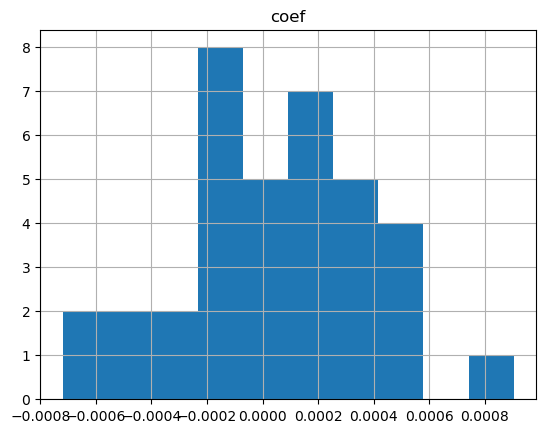

In [5]:
m_coef = pd.DataFrame({"feature": m.get_features_list(), "coef": m.get_params()})
season_coef = m_coef[m_coef.feature.str.contains('FS')]
season_coef.hist()

## Will be doing (after 08/19): TS clustering
- start from compute_mask import

In [ ]:
s_x = np.array(
    [-0.790, -0.765, -0.734, -0.700, -0.668, -0.639, -0.612, -0.587, -0.564,
     -0.544, -0.529, -0.518, -0.509, -0.502, -0.494, -0.488, -0.482, -0.475,
     -0.472, -0.470, -0.465, -0.464, -0.461, -0.458, -0.459, -0.460, -0.459,
     -0.458, -0.448, -0.431, -0.408, -0.375, -0.333, -0.277, -0.196, -0.090,
     0.047, 0.220, 0.426, 0.671, 0.962, 1.300, 1.683, 2.096, 2.510, 2.895,
     3.219, 3.463, 3.621, 3.700, 3.713, 3.677, 3.606, 3.510, 3.400, 3.280,
     3.158, 3.038, 2.919, 2.801, 2.676, 2.538, 2.382, 2.206, 2.016, 1.821,
     1.627, 1.439, 1.260, 1.085, 0.917, 0.758, 0.608, 0.476, 0.361, 0.259,
     0.173, 0.096, 0.027, -0.032, -0.087, -0.137, -0.179, -0.221, -0.260,
     -0.293, -0.328, -0.359, -0.385, -0.413, -0.437, -0.458, -0.480, -0.498,
     -0.512, -0.526, -0.536, -0.544, -0.552, -0.556, -0.561, -0.565, -0.568,
     -0.570, -0.570, -0.566, -0.560, -0.549, -0.532, -0.510, -0.480, -0.443,
     -0.402, -0.357, -0.308, -0.256, -0.200, -0.139, -0.073, -0.003, 0.066,
     0.131, 0.186, 0.229, 0.259, 0.276, 0.280, 0.272, 0.256, 0.234, 0.209,
     0.186, 0.162, 0.139, 0.112, 0.081, 0.046, 0.008, -0.032, -0.071, -0.110,
     -0.147, -0.180, -0.210, -0.235, -0.256, -0.275, -0.292, -0.307, -0.320,
     -0.332, -0.344, -0.355, -0.363, -0.367, -0.364, -0.351, -0.330, -0.299,
     -0.260, -0.217, -0.172, -0.128, -0.091, -0.060, -0.036, -0.022, -0.016,
     -0.020, -0.037, -0.065, -0.104, -0.151, -0.201, -0.253, -0.302, -0.347,
     -0.388, -0.426, -0.460, -0.491, -0.517, -0.539, -0.558, -0.575, -0.588,
     -0.600, -0.606, -0.607, -0.604, -0.598, -0.589, -0.577, -0.558, -0.531,
     -0.496, -0.454, -0.410, -0.364, -0.318, -0.276, -0.237, -0.203, -0.176,
     -0.157, -0.145, -0.142, -0.145, -0.154, -0.168, -0.185, -0.206, -0.230,
     -0.256, -0.286, -0.318, -0.351, -0.383, -0.414, -0.442, -0.467, -0.489,
     -0.508, -0.523, -0.535, -0.544, -0.552, -0.557, -0.560, -0.560, -0.557,
     -0.551, -0.542, -0.531, -0.519, -0.507, -0.494, -0.484, -0.476, -0.469,
     -0.463, -0.456, -0.449, -0.442, -0.435, -0.431, -0.429, -0.430, -0.435,
     -0.442, -0.452, -0.465, -0.479, -0.493, -0.506, -0.517, -0.526, -0.535,
     -0.548, -0.567, -0.592, -0.622, -0.655, -0.690, -0.728, -0.764, -0.795,
     -0.815, -0.823, -0.821])

s_y1 = np.concatenate((s_x, s_x)).reshape((-1, 1))
s_y2 = np.concatenate((s_x, s_x[::-1])).reshape((-1, 1))
sz = s_y1.shape[0]

path, sim = dtw_path(s_y1, s_y2)

plt.figure(1, figsize=(8, 8))

# definitions for the axes
left, bottom = 0.01, 0.1
w_ts = h_ts = 0.2
left_h = left + w_ts + 0.02
width = height = 0.65
bottom_h = bottom + height + 0.02

rect_s_y = [left, bottom, w_ts, height]
rect_gram = [left_h, bottom, width, height]
rect_s_x = [left_h, bottom_h, width, h_ts]

ax_gram = plt.axes(rect_gram)
ax_s_x = plt.axes(rect_s_x)
ax_s_y = plt.axes(rect_s_y)

mat = cdist(s_y1, s_y2)

ax_gram.imshow(mat, origin='lower')
ax_gram.axis("off")
ax_gram.autoscale(False)
ax_gram.plot([j for (i, j) in path], [i for (i, j) in path], "w-",
             linewidth=3.)

ax_s_x.plot(numpy.arange(sz), s_y2, "b-", linewidth=3.)
ax_s_x.axis("off")
ax_s_x.set_xlim((0, sz - 1))

ax_s_y.plot(- s_y1, numpy.arange(sz), "b-", linewidth=3.)
ax_s_y.axis("off")
ax_s_y.set_ylim((0, sz - 1))

plt.tight_layout()
plt.show()

In [ ]:
def train_step_raw(images, generator, discriminator, generator_optimizer, discriminator_optimizer, choice, pre_trained=None):
    noise = tf.random.normal((images.shape[0],) + generator.input_shape[1:])

    with tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      real_output = discriminator(images, training=True)
      fake_output = discriminator(generated_images, training=True)

      if choice == 'wgan_gp':
        disc_loss = discriminator_loss(real_output, fake_output, choice, generated_images = generated_images, images= images, discriminator=discriminator)
      else:
        disc_loss = discriminator_loss(real_output, fake_output, choice)

    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)   
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    noise = tf.random.normal((images.shape[0],) + generator.input_shape[1:])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
      generated_images = generator(noise, training=True)

      fake_output = discriminator(generated_images, training=True)

      gen_loss = generator_loss(fake_output, choice)

      if pre_trained is not None: 
        pre_trained_output = pre_trained(generated_images, training=True) # 0 or 1 from D2
        gen_loss += generator_loss(pre_trained_output, choice)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)     
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    
    return gen_loss, disc_loss

In [ ]:
def train(dataset, batchsize, generator, discriminator, G_opt, D_opt, test, epochs, choice, pre_trained=None):
  train_step = tf.function(train_step_raw)
  dataset = dataset.astype('float32')
  image_batch = tf.Variable(initial_value=np.zeros((batchsize,)+dataset.shape[1:]), trainable=False, dtype='float32')
  datasize = dataset.shape[0]

  for epoch in range(epochs):
    start = time.time()

    G_list = []; D_list = []

    for i in range(datasize//batchsize):
      image_batch.assign(dataset[np.random.choice(datasize, size=batchsize, replace=False)])
      gen_loss, disc_loss = train_step(image_batch, generator, discriminator, G_opt, D_opt, choice, pre_trained)
      G_list.append(gen_loss)
      D_list.append(disc_loss) 

    G_loss.append(np.mean(G_list))
    D_loss.append(np.mean(D_list))

    for fun, seed in test:
      fun(generator, epoch + 1, seed) 

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

## Quant GAN

In [ ]:
# official

prelu_kwargs = {'alpha_initializer':tf.keras.initializers.Constant(value=0.25), 'shared_axes':[1,2]}

def TemporalBlock(x, skip, output_dim, hidden_dim_skip, kernel_size, dilation, num_inner_blocks=2, batch_norm=False, **kwargs):
    drop_left = num_inner_blocks * (kernel_size - 1) * dilation
    in_dim = x.shape[-1]

    x_0 = x

    for i in range(num_inner_blocks):
      init = tf.keras.initializers.RandomUniform(minval=-1/np.sqrt(x.shape[2]*kernel_size), maxval=1/np.sqrt(x.shape[2]*kernel_size))
      inits = {'kernel_initializer': init, 'bias_initializer': init}
      x = tfa.layers.SpectralNormalization(layers.Conv1D(output_dim, kernel_size, strides=1, 
                                                       padding='valid', dilation_rate=dilation, **inits, **kwargs))(x)
      x = layers.PReLU(**prelu_kwargs)(x) 
      if batch_norm:
        x = layers.BatchNormalization()(x)
    
    if in_dim != output_dim: 
      init = tf.keras.initializers.RandomUniform(minval=-1/np.sqrt(x_0.shape[2]*1), maxval=1/np.sqrt(x_0.shape[2]*1))
      inits = {'kernel_initializer': init, 'bias_initializer': init}
      x_0 = tfa.layers.SpectralNormalization(layers.Conv1D(output_dim, 1, strides=1, padding='same', **inits, **kwargs))(x_0) 
    
    x = x + x_0[:,drop_left:]
    init = tf.keras.initializers.RandomUniform(minval=-1/np.sqrt(x.shape[2]*1), maxval=1/np.sqrt(x.shape[2]*1))
    inits = {'kernel_initializer': init, 'bias_initializer': init}
    skip = skip + tfa.layers.SpectralNormalization(layers.Conv1D(hidden_dim_skip, 1, strides=1, padding='same', **inits, **kwargs))(x[:, -skip.shape[1]:])
    
    return layers.PReLU(**prelu_kwargs)(x), skip

def TCN(x, output_dim, hidden_dims, hidden_dim_skip=50, 
        kernel_size=2, num_inner_blocks=2, dilation_factor=2, batch_norm=False, **kwargs):
    drop_left =  sum(num_inner_blocks * (kernel_size - 1) * dilation_factor**min(i,6) for i in range(len(hidden_dims)))
    skip = tf.zeros([tf.shape(x)[0], x.shape[1] - drop_left, hidden_dim_skip])
    
    x, skip = TemporalBlock(x, skip, hidden_dims[0], hidden_dim_skip, 1, 1, num_inner_blocks=2, batch_norm=batch_norm, **kwargs)
    for i, h in enumerate(hidden_dims):
        x, skip = TemporalBlock(x, skip, h, hidden_dim_skip, kernel_size, dilation_factor**min(i,6), num_inner_blocks=2, batch_norm=batch_norm, **kwargs)
    
    y = layers.PReLU(**prelu_kwargs)(skip) 
    init = tf.keras.initializers.RandomUniform(minval=-1/np.sqrt(y.shape[2]*1), maxval=1/np.sqrt(y.shape[2]*1))
    inits = {'kernel_initializer': init, 'bias_initializer': init}
    y = tfa.layers.SpectralNormalization(layers.Conv1D(hidden_dim_skip, 1, strides=1, padding='same', **inits, **kwargs))(y) 
    y = layers.PReLU(**prelu_kwargs)(y) 
    y = tfa.layers.SpectralNormalization(layers.Conv1D(output_dim, 1, strides=1, padding='same', **inits, **kwargs))(y) 
    return y